# Google Trends Time Series Analysis
This notebook analyses interest over time for selected keywords using Google Trends data via the `pytrends` API.

**Author**: Sheryll Dumapal  
**License**: Personal and non-commercial use only. © 2025 Sheryll Dumapal. 

## Setup
Install required libraries if they are not already installed.

In [61]:
# !pip install pytrends

## Importing Libraries

In [87]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pytrends.request import TrendReq 
import time
import platform

## Connect to Google Trends

In [105]:
# Initialize pytrends object with USA settings
pytrends = TrendReq(
    hl='en-US',     # Language setting to (US English)
    tz=360,         # Timezone offset for US (UTC-6)
    timeout=(10, 25),
)

## Define Search Keywords

In [106]:
# Creating a list of keywords to search 
kw_list = ['bitcoin', 'ethereum', 'dogecoin', 'blockchain', 'nft']

# Retrieve Data Trend

In [107]:
# Payload for Google Trends data
pytrends.build_payload(
    kw_list=kw_list,
    cat=0,
    timeframe='today 5-y',
    geo='US',          
    gprop=''         
)

# Wait to respect rate limits
time.sleep(10)

# Fetching the interest over time data
df_trend = pytrends.interest_over_time()

# Data summary
print(df_trend.info())
print(df_trend.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 262 entries, 2020-05-17 to 2025-05-18
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   bitcoin     262 non-null    int64
 1   ethereum    262 non-null    int64
 2   dogecoin    262 non-null    int64
 3   blockchain  262 non-null    int64
 4   nft         262 non-null    int64
 5   isPartial   262 non-null    bool 
dtypes: bool(1), int64(5)
memory usage: 12.5 KB
None
            bitcoin  ethereum  dogecoin  blockchain  nft  isPartial
date                                                               
2020-05-17       14         1         0           1    0      False
2020-05-24       12         1         0           1    0      False
2020-05-31       13         1         0           1    0      False
2020-06-07       11         1         0           1    0      False
2020-06-14       11         1         0           1    0      False


/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


## Data Quality Check

In [97]:
print(df_trend.describe())
print(df_trend.isnull().sum())

          bitcoin    ethereum    dogecoin  blockchain         nft
count  262.000000  262.000000  262.000000  262.000000  262.000000
mean    24.797710    4.656489    5.190840    1.259542    3.717557
std     13.586995    4.149082   13.640493    0.480864    5.453074
min      9.000000    1.000000    0.000000    1.000000    0.000000
25%     15.000000    2.000000    1.000000    1.000000    1.000000
50%     20.000000    3.000000    2.000000    1.000000    1.000000
75%     30.000000    6.000000    4.000000    1.000000    4.000000
max     81.000000   29.000000  100.000000    3.000000   28.000000
bitcoin       0
ethereum      0
dogecoin      0
blockchain    0
nft           0
isPartial     0
dtype: int64


## Visualise Interest Over Time

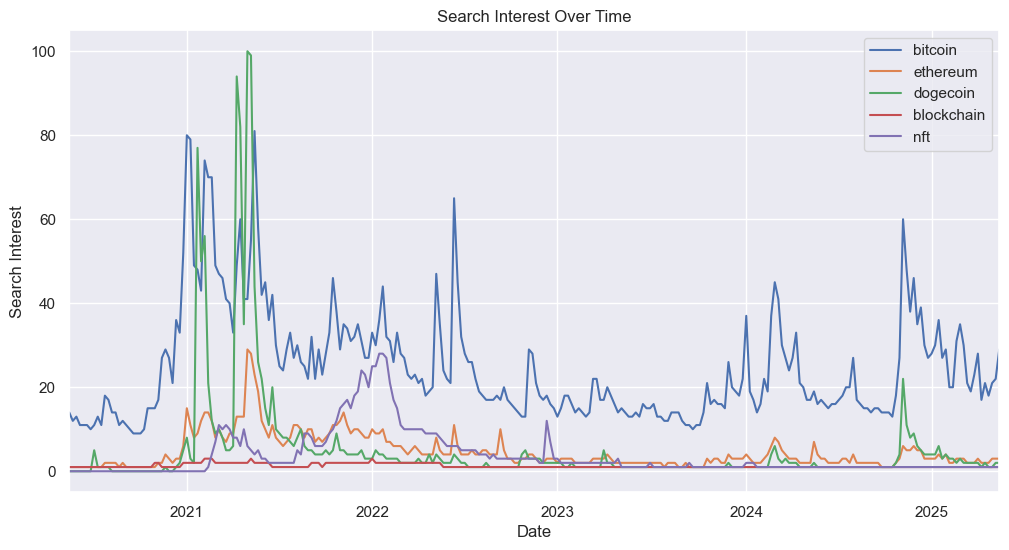

In [98]:
df_trend[kw_list].plot(figsize=(12,6), title='Search Interest Over Time')
plt.ylabel('Search Interest')
plt.xlabel('Date')
plt.grid(True)
plt.show()

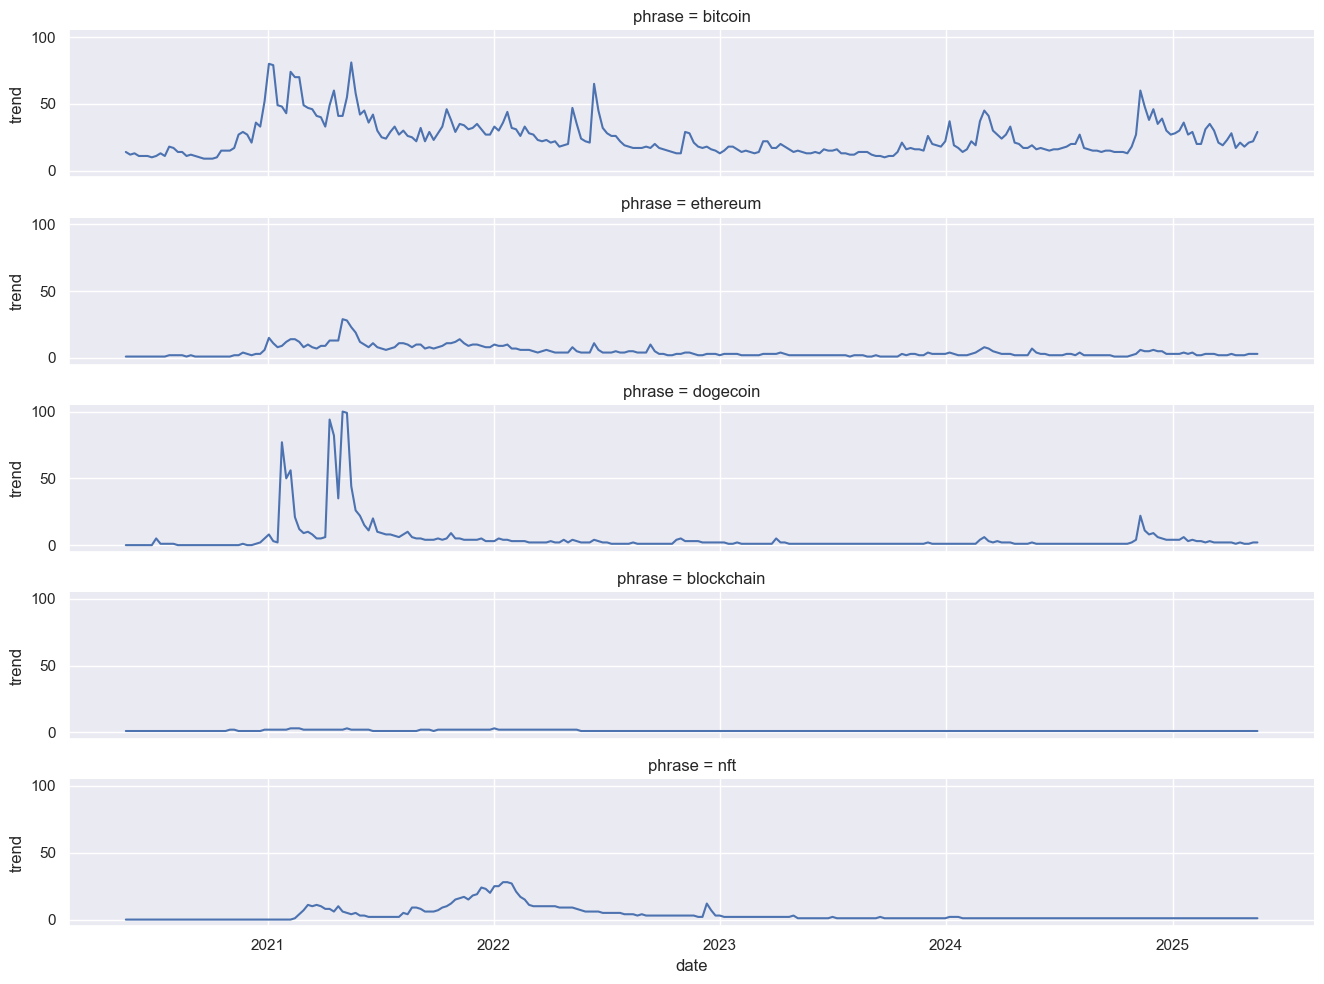

In [99]:
# Plotsize for the graphs 
sns.set(rc={'figure.figsize':(10,5)})

plot_data = df_trend.iloc[:, 0:len(df_trend.columns)-1]
plot_data = plot_data.reset_index() \
    .melt(id_vars='date', 
          var_name='phrase', 
          value_name='trend')

# Plot 
g = sns.relplot(data=plot_data, 
                x='date', 
                y='trend', 
                kind='line', 
                row='phrase', 
                height=2.0, 
                aspect=6.7)

/opt/anaconda3/lib/python3.12/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


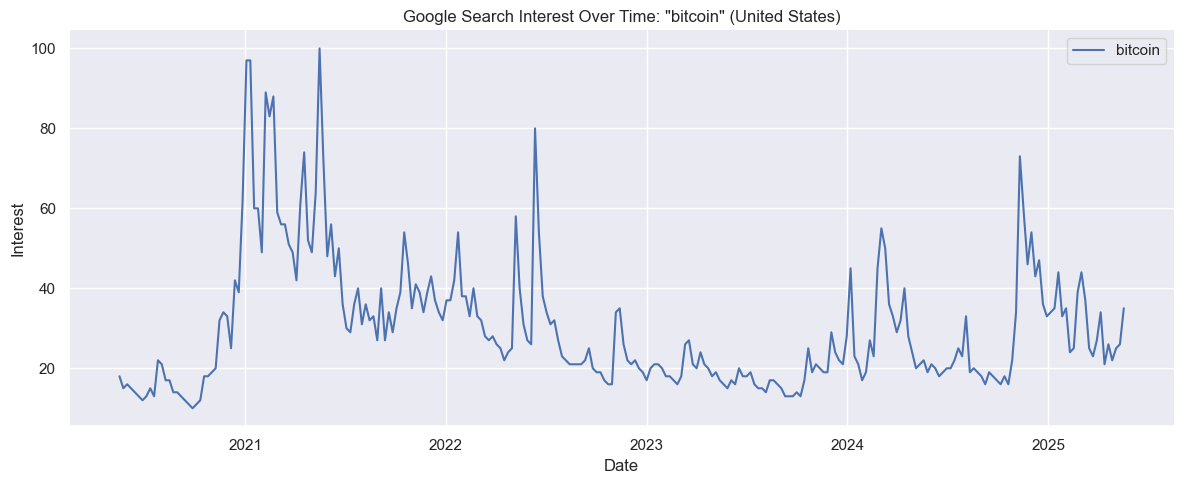

In [109]:
# Note: returns different values when the phrase is queried on its own.
kw_list = ['bitcoin']
pytrends.build_payload(kw_list,
                       cat=0,
                       timeframe='today 5-y',
                       geo='US',
                       gprop='')

# Pausing to respect rate limits ;).
time.sleep(5)

# Retrieving interest over time for the keyword
df_trend_single = pytrends.interest_over_time()

# Ploting the search trend
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_trend_single.iloc[:,0:1])
plt.title(f'Google Search Interest Over Time: "{kw_list[0]}" (United States)')
plt.xlabel('Date')
plt.ylabel('Interest')
sns.despine()
plt.grid(True)
plt.tight_layout()
plt.show()

## Timeseries Decomposition
The `statsmodels` package offers tools to decompose a time series into components. This is useful for identifying trends, seasonality, and residual patterns, especially for forecasting.

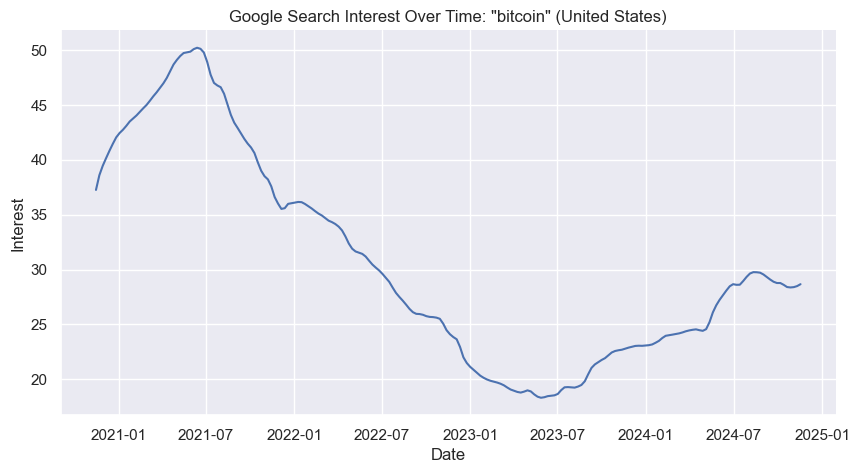

In [110]:
# Execute decompose for a time series
df = df_trend_single.iloc[:,0:1]
decompose = sm.tsa.seasonal_decompose(df,
                                      model='additive')

# Plotting the Trends 
sns.lineplot(data=decompose.trend)
plt.xlabel('Date')
plt.ylabel('Interest')
plt.title(f'Google Search Interest Over Time: "{kw_list[0]}" (United States)')
sns.despine()
plt.show()

Text(0.5, 0.98, 'Seasonal Decomposition of Google Search Interest: "bitcoin" (United States)')

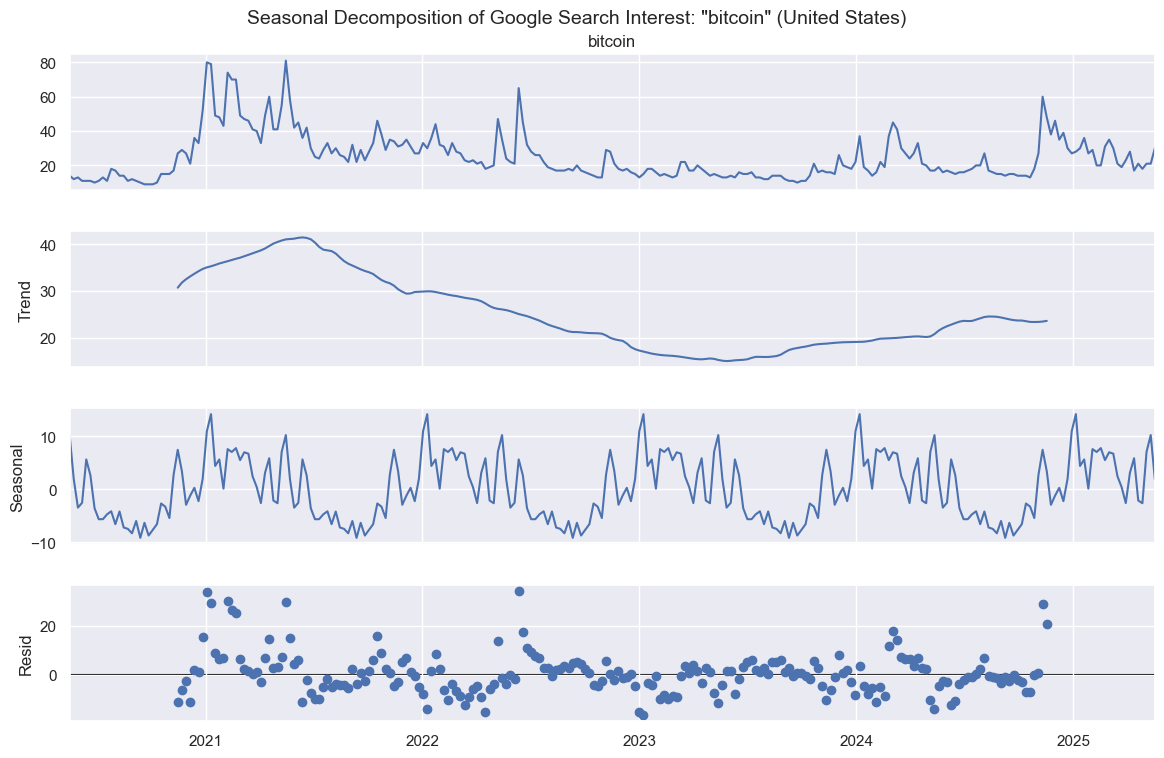

In [111]:
# Decompose a single time series (e.g., bitcoin)
decomposition = sm.tsa.seasonal_decompose(df_trend['bitcoin'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
fig.suptitle(f'Seasonal Decomposition of Google Search Interest: "{kw_list[0]}" (United States)', fontsize=14)

## Summary and Next Steps
- Trends for AI-related topics show strong seasonality and growth.
- Decomposition helps identify patterns and could feed into predictive models.

**Next steps**:
- Apply decomposition to other keywords.
- Explore predictive modelling using ARIMA or Prophet.
- Combine with sentiment or volume data for deeper insight.